In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    gamma = discount_factor
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        s_t = env.reset()
        a_probs = policy(s_t)
        a_t = np.random.choice(np.arange(len(a_probs)), p=a_probs)
        
        stats.episode_lengths[i_episode] += 1
        
        while True:
            
            s_t_1, r_t, done, _ = env.step(a_t)
            a_probs = policy(s_t_1)
            a_t_1 = np.random.choice(np.arange(len(a_probs)), p=a_probs)
            Q[s_t][a_t] = Q[s_t][a_t] + alpha * (r_t + gamma * Q[s_t_1][a_t_1] - Q[s_t][a_t])
            
            s_t = s_t_1
            a_t = a_t_1
            
            # Update statistics
            stats.episode_rewards[i_episode] += r_t
            stats.episode_lengths[i_episode] += 1
            
            if done:
                break
        # Implement this!
    
    return Q, stats

In [5]:
Q, stats = sarsa(env, 200)

Episode 200/200.

这三个图其实意思都差不多
- 图1：Episode的长度 随 时间的变化。Episode的长度越短，代表越快到达 G，这说明 PI 逐渐找到了最优解。
- 图2：和图1意思差不多，Episode的长度 = -1 * Episode Reward
- 图3：和图1的意思也差不多，曲线越陡，代表一个Episode所用的timestep越少，即episode越短

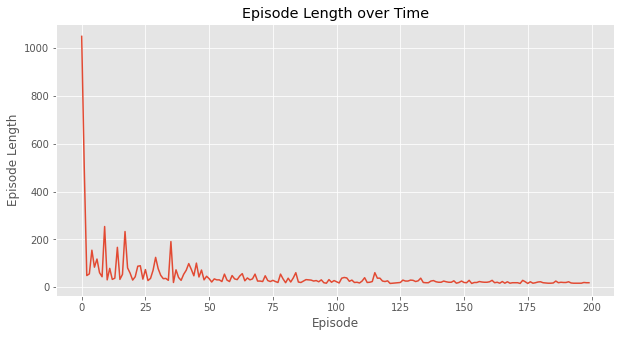

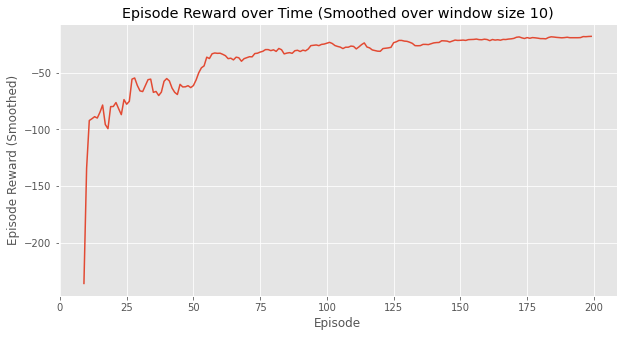

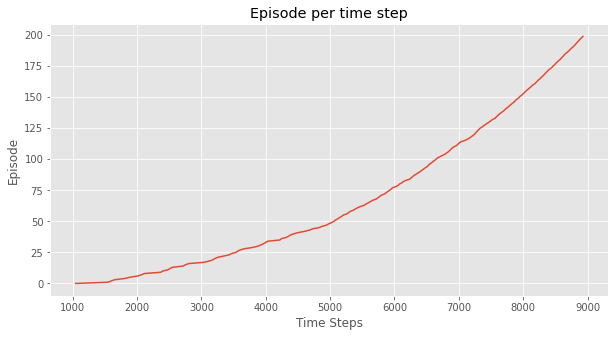

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)